In [21]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF
import time

### 1D case

In [22]:
key = random.PRNGKey(int(time.time()))

def func(x,noise=0.0):
    return jnp.sin(x) + noise*random.normal(key,x.shape)

def grad_func(x,noise=0.0):
    return jnp.cos(x) + noise*random.normal(key,x.shape)

In [23]:
bounds = jnp.array([0.0, 2*jnp.pi])

noise = 0.1

length_scale = 1.0

num_datapoints = 3
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = func(datagrid,noise)
num_derivpoints = (9,)
derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_values = grad_func(derivative_grid,noise)
data_split = (num_datapoints, ) + num_derivpoints

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1,1)

num_referencepoints = 5
referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()
kernel_params = (length_scale, )

init_kernel = (0.5, )
init_noise = 1.0

In [24]:
model = gpr.ApproximateGPR(kernel,data_split,referencegrid,kernel_params=init_kernel,noise=init_noise)
model.train(X_data,Y_data)
(means_ppa, stds_ppa) = model.eval(grid.reshape(-1,1),True)
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

model = gpr.ExactGPR(kernel,data_split,kernel_params=init_kernel,noise=init_noise)
model.train(X_data,Y_data)
(means_full, stds_full) = model.eval(grid.reshape(-1,1),True)
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

OptStep(params=DeviceArray([0.16296722, 2.0881414 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.00106538, dtype=float32, weak_type=True), success=True, status=0, iter_num=7))
OptStep(params=DeviceArray([0.12371586, 1.6870899 ], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.00132361, dtype=float32, weak_type=True), success=True, status=0, iter_num=7))


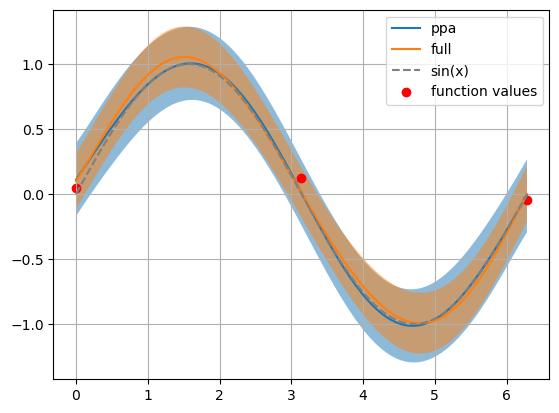

In [25]:
plt.plot(grid,means_ppa,label="ppa")
plt.fill_between(grid,means_ppa-2*stds_ppa,means_ppa+2*stds_ppa,alpha=0.5)
plt.plot(grid,means_full,label="full")
plt.fill_between(grid,means_full-2*stds_full,means_full+2*stds_full,alpha=0.5)
plt.plot(grid,func(grid),color="grey",ls="--",label="sin(x)")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.grid()
plt.legend()